In [2]:
import os
import simulation
import pynbody
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import ipywidgets
import tqdm
import pickle

In [3]:
SIMPATH = '/media/michele/My Book/Michele/MySimulations/MovingBox/beta'

In [4]:
# dirs = os.walk('/media/michele/My Book/Michele/MySimulations/MovingBox/beta')
# tuple(dirs)

In [5]:
SIM = 'mb.69002'
TRAJ = 'p100_a800_r600'
TIME_LIMIT = 12

In [6]:
from pynbody.units import kpc, km, s, Msol
M = 10*10 * Msol
L = kpc
V = km/s
T = L/V

conv_fac = T.in_units('Gyr')
conv_fac

0.9778139512067809

In [7]:
sim = simulation.Simulation(os.path.join(SIMPATH, "{}/{}".format(SIM, TRAJ), "out"))

loading simulation: /media/michele/My Book/Michele/MySimulations/MovingBox/beta/mb.69002/p100_a800_r600/out
Found parameter file
Found compiler file
Loading cosmological parameters
Found trace file


In [12]:
sim

/media/michele/My Book/Michele/MySimulations/MovingBox/beta/mb.69002/p100_a800_r600/out: (351) <SimSnap "/media/michele/My Book/Michele/MySimulations/MovingBox/beta/mb.69002/p100_a800_r600/out/snapshot_0001" len=590956>

In [ ]:
def sigma(vel):
    return np.sqrt(((vel - vel.mean(axis=0))**2).mean())

In [10]:
sphere = pynbody.filt.Sphere(5 * pynbody.units.kpc)
mass = list()
r_eff = list()
for snap in tqdm.tqdm(sim.snap_list):
    pynbody.analysis.halo.center(snap.s, vel=False)
    mass.append(snap.s[sphere]['mass'].sum().in_units('Msol'))
    r_eff.append(pynbody.analysis.luminosity.half_light_r(snap))

100%|██████████| 383/383 [01:05<00:00,  5.89it/s]


In [11]:
sigma_star = list()
sigma_gas = list()
for snap in tqdm.tqdm(sim.snap_list):
    sigma_star.append(sigma(snap.s[sphere]['vel']))
    sigma_gas.append(sigma(snap.g[sphere]['vel']))

100%|██████████| 383/383 [00:11<00:00, 33.21it/s]


In [9]:
times, mass, sigma_star, sigma_gas, r_eff = pickle.load(open('{}{}.pickle'.format(SIM,TRAJ), 'rb'))

loading simulation: 69002


10.941722579161485


Getting sumfile: /home/michele/sim/MoRIA/results/sumfiles/69002.dat


Fixing cosmological parameters of MoRIA simulation
0 Time [Gyr]
1 Time [Gyr]
2 Time [Gyr]
3 Time [Gyr]
4 Time [Gyr]
5 $z$
6 
7 $z$


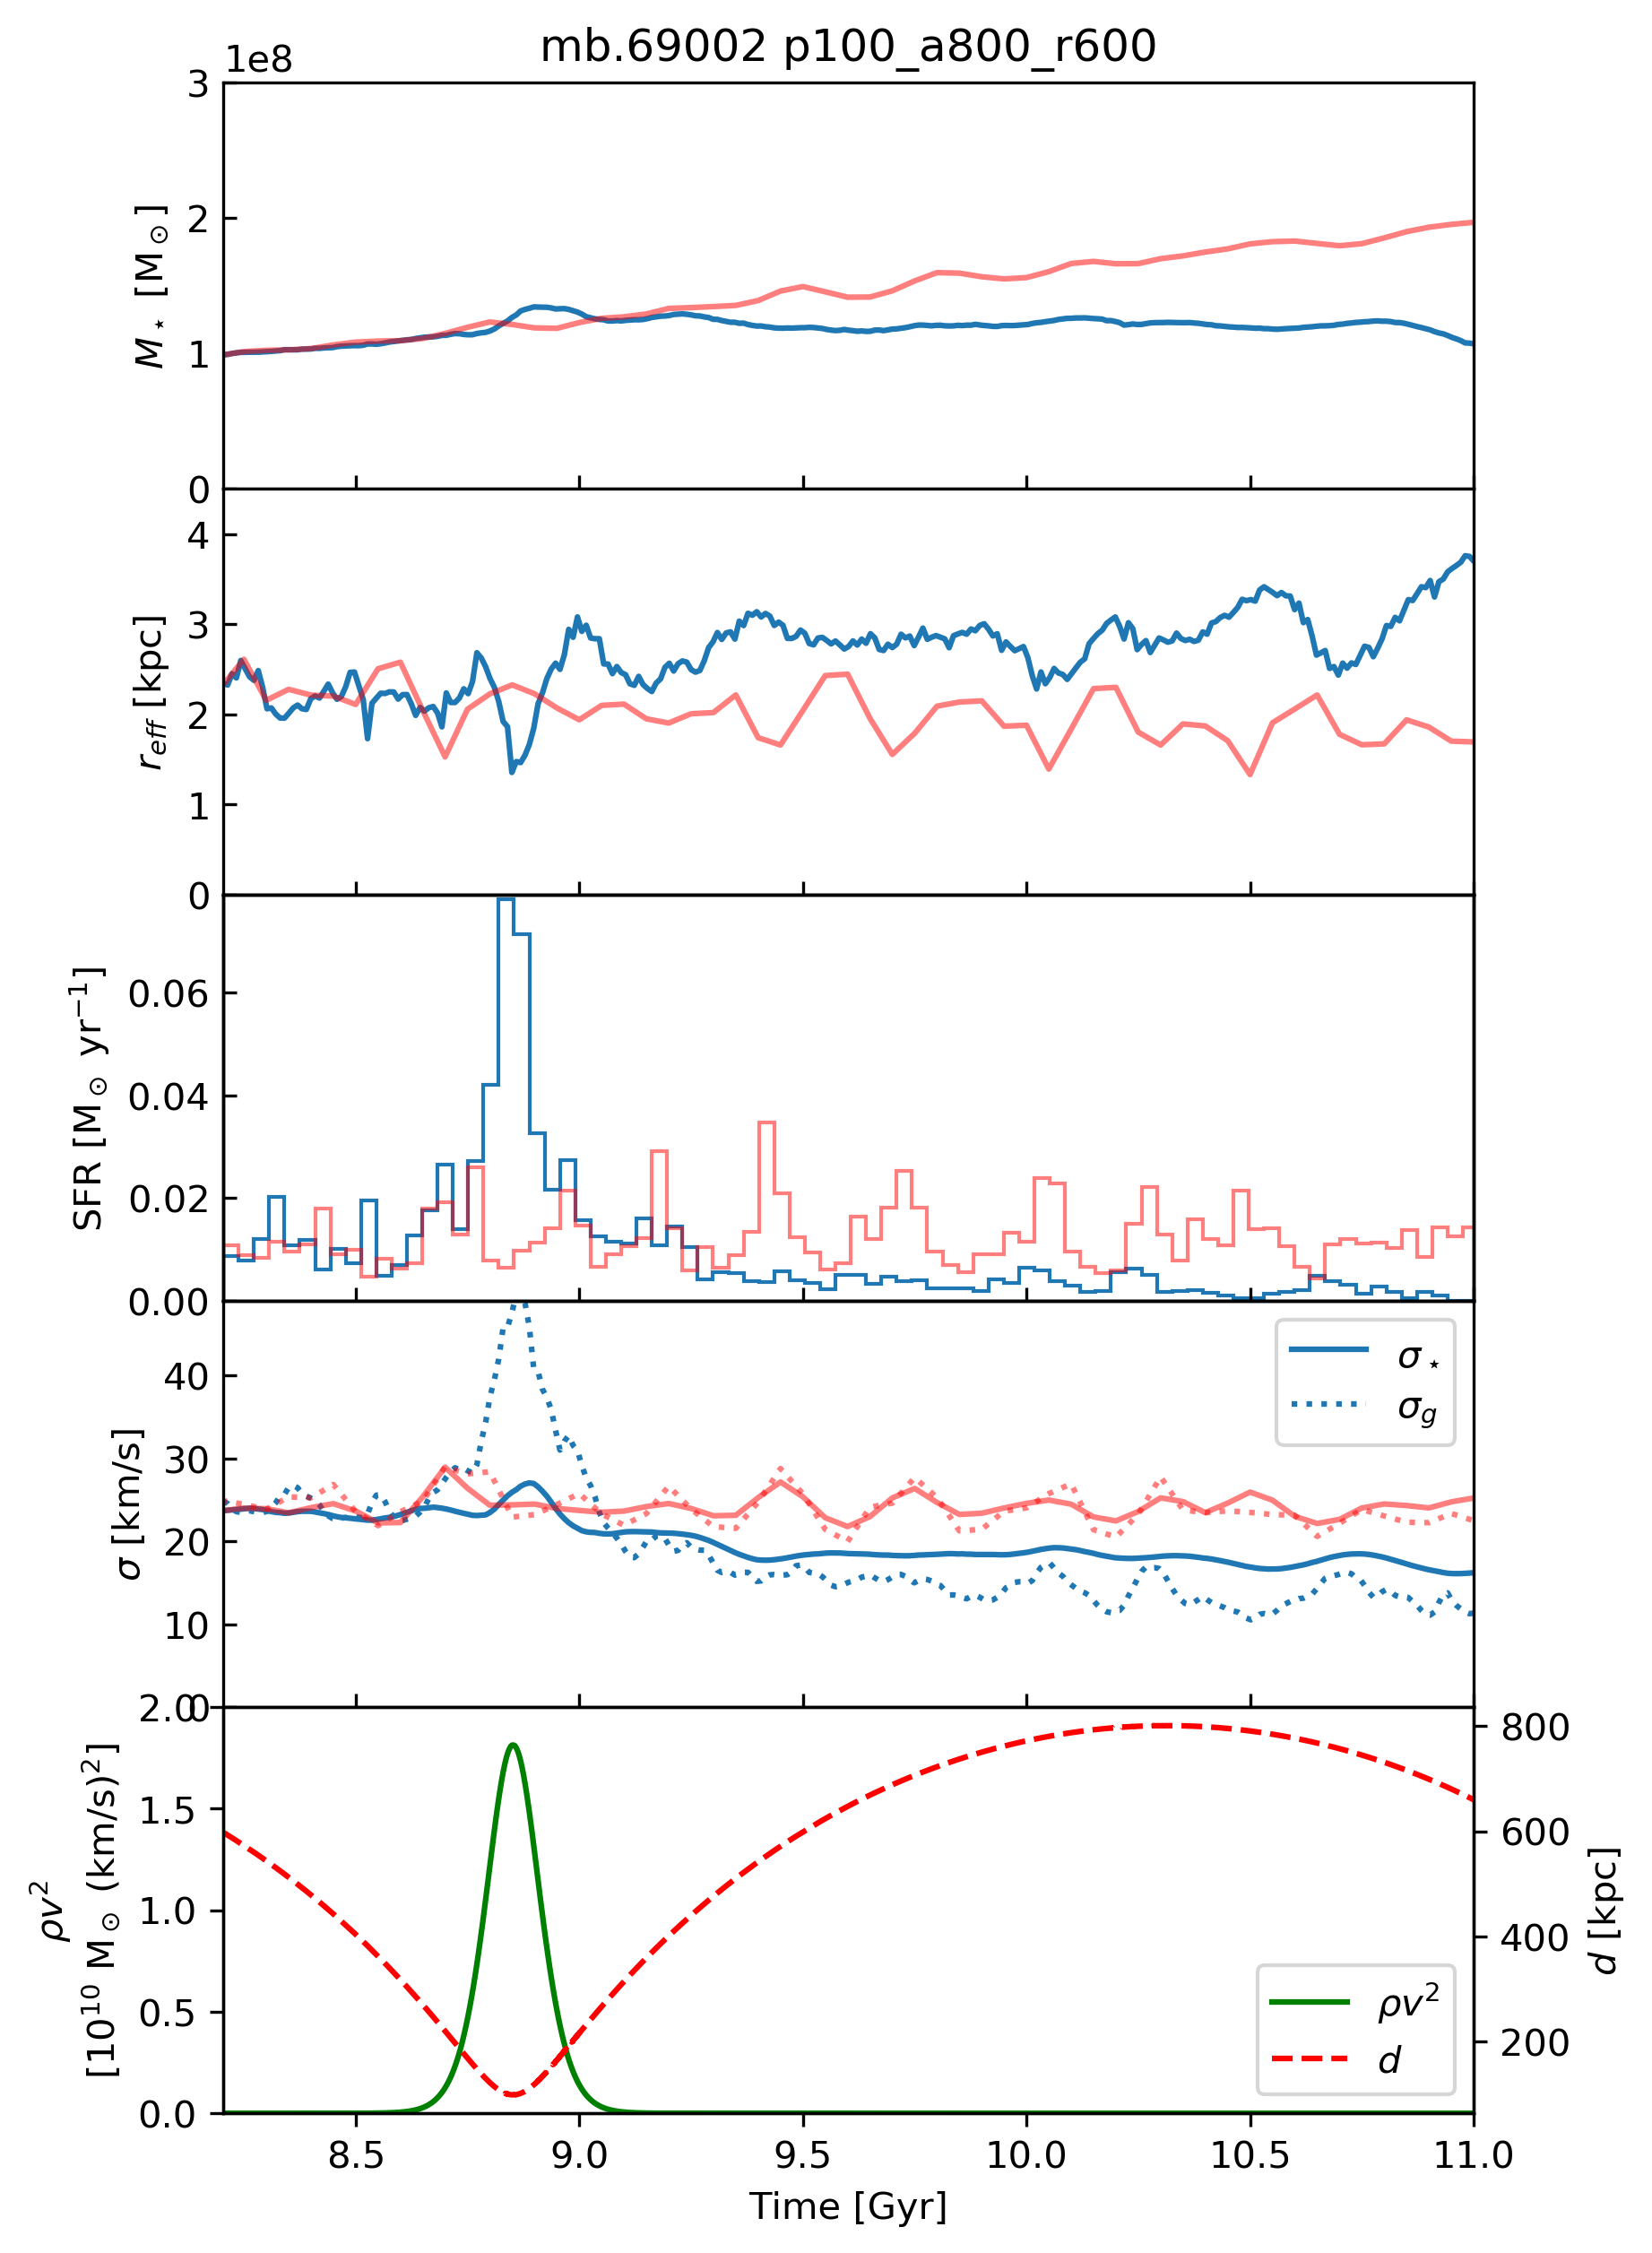

In [24]:
# times = sim.times
fig, (ax_m_star, ax_r_eff, ax_sfh, ax_sigma, ax_ram) = plt.subplots(5, figsize=(6,10), dpi=300)
ax_m_star.plot(times, mass)
ax_m_star.set_xlabel("Time [Gyr]")
ax_m_star.set_ylabel("$M_\star$ [M$_\odot]$");
ax_m_star.ticklabel_format(style='sci', scilimits=(0,0))

ax_r_eff.plot(times, r_eff)
ax_r_eff.set_xlabel("Time [Gyr]")
ax_r_eff.set_ylabel("$r_{eff}$ [kpc]");

last_snap = 280
sim.plot_sfh(ax_sfh, range=(times[0], times[-1]), last_snap=last_snap);
# snap1 = sim[200]
# snap2 = sim[300]
print(sim[last_snap].properties['time'].in_units('Gyr'))
# pynbody.plot.sfh(snap2, range=(sim.times[0], sim.times[-1]), subplot=ax_sfh, color='C0')
# pynbody.plot.sfh(snap1, range=(sim.times[0], snap1.properties['time'].in_units('Gyr')), subplot=ax_sfh, color='C0')
# pynbody.plot.sfh(snap2, range=(snap1.properties['time'].in_units('Gyr'), sim.times[-1]), subplot=ax_sfh, color='C0')

# ax_sfh.ticklabel_format(style='sci', scilimits=(0,0))

# ax_r.plot(sim.trace.t, sim.trace.r, '--', color='r', alpha=0.5, label='$d$')
ax_ram.plot(sim.dens_trace.t*conv_fac, sim.ram_pressure, color='g', label=r'$\rho v^2$')
ax_d = ax_ram.twinx()
ax_d.plot(sim.dens_trace.t*conv_fac, sim.dens_trace.r, 'r--', label='$d$')
ax_d.set_ylabel("$d$ [kpc]")
# ax_ram.legend();
# ax_d.legend();

# Manage the labels
lines2, labels2 = ax_d.get_legend_handles_labels()
lines, labels = ax_ram.get_legend_handles_labels()
ax_d.legend(lines + lines2, labels + labels2, loc=0)

ax_ram.set_xlabel("Time [Gyr]")
ax_ram.set_ylabel(r"""$\rho v^2$
[$10^{10}$ M$_\odot$ (km/s)$^2$]""");


ax_sigma.plot(sim.times, sigma_star, label='$\sigma_\star$')
ax_sigma.plot(sim.times, sigma_gas, 'C0:', label='$\sigma_g$')
ax_sigma.set_xlabel("Time [Gyr]")
ax_sigma.set_ylabel("$\sigma$ [km/s]");
ax_sigma.legend();
# [a.semilogy() for a in fig.axes]

if SIM.endswith('71002'):
    # data = [sim.times, mass, sigma_star, sigma_gas, r_eff]
    data = pickle.load(open('moria71002.pickle', 'rb'))
    alpha = 0.5
    ax_m_star.plot(data[0][65:], data[1][65:], 'r', alpha=alpha);
    ax_r_eff.plot(data[0][65:], data[4][65:], 'r', alpha=alpha);
    ax_sigma.plot(data[0][65:], data[2][65:], 'r', alpha=alpha);
    ax_sigma.plot(data[0][65:], data[3][65:], 'r:', alpha=alpha);

    snap = simulation.MoriaSim('71002')[-1]
    pynbody.plot.sfh(snap, range=(sim.times[0], sim.times[-1]), subplot=ax_sfh, bins=100, alpha=alpha, color='r')
    ax_sfh.set_ylim(ymax=0.029)

    ax_m_star.set_ylim(ymin=0, ymax=0.9e8)
    ax_r_eff.set_ylim(ymin=0, ymax=4.5)
    ax_sigma.set_ylim(ymin=0, ymax=39)
    ax_ram.set_ylim(ymin=0, ymax=0.014)
    if TRAJ[1] == '1':
        for ax in fig.axes:
            ax.set_xlim(sim.times[0], sim.times[-1])
    if TRAJ[1] == '1':
        ax_ram.set_ylim(ymin=0, ymax=2)
    elif TRAJ[1] == '3':
        ax_ram.set_ylim(ymin=0, ymax=0.014)

elif SIM.endswith('62002'):
    # data = [sim.times, mass, sigma_star, sigma_gas, r_eff]
    data = pickle.load(open('moria62002.pickle', 'rb'))
    alpha = 0.5
    snap = simulation.MoriaSim('62002')[-1]
    ax_m_star.plot(data[0][65:], data[1][65:], 'r', alpha=alpha);
    ax_r_eff.plot(data[0][65:], data[4][65:], 'r', alpha=alpha);
    ax_sigma.plot(data[0][65:], data[2][65:], 'r', alpha=alpha);
    pynbody.plot.sfh(snap, range=(sim.times[0], sim.times[-1]), subplot=ax_sfh, bins=100, alpha=alpha, color='r')
    
    fig.axes[7].set_xlabel('')
    
    ax_m_star.set_ylim(ymin=0, ymax=9e6)
    ax_r_eff.set_ylim(ymin=0, ymax=4.5)
    ax_sigma.set_ylim(ymin=0, ymax=39)
    ax_ram.set_ylim(ymin=0, ymax=0.014)
elif SIM.endswith('69002'):
    # data = [sim.times, mass, sigma_star, sigma_gas, r_eff]
    data = pickle.load(open('moria69002.pickle', 'rb'))
    alpha = 0.5
    snap = simulation.MoriaSim('69002')[-1]
    ax_m_star.plot(data[0][65:], data[1][65:], 'r', alpha=alpha);
    ax_r_eff.plot(data[0][65:], data[4][65:], 'r', alpha=alpha);
    ax_sigma.plot(data[0][65:], data[2][65:], 'r', alpha=alpha)
    ax_sigma.plot(data[0][65:], data[3][65:], 'r:', alpha=alpha);

    pynbody.plot.sfh(snap, range=(sim.times[0], sim.times[-1]), subplot=ax_sfh, bins=100, alpha=alpha, color='r')
    ax_sfh.set_ylim(ymax=0.079)

    ax_m_star.set_ylim(ymin=0, ymax=3e8)
    ax_r_eff.set_ylim(ymin=0, ymax=4.5)
    ax_sigma.set_ylim(ymin=0, ymax=49)
    if TRAJ[1] == '1':
        for ax in fig.axes:
#             ax.set_xlim(sim.times[0], sim.times[-1])
            ax.set_xlim(sim.times[0], 11)
    if TRAJ[1] == '1':
        ax_ram.set_ylim(ymin=0, ymax=2)
    elif TRAJ[1] == '3':
        ax_ram.set_ylim(ymin=0, ymax=0.014)

if TRAJ[1] == '3':
    for ax in fig.axes:
        ax.set_xlim(sim.times[0], 12)
# elif TRAJ[1] == '1':
#     for ax in fig.axes:
#         ax.set_xlim(sim.times[0], 11)

fig.subplots_adjust(hspace=0)

for i, ax in enumerate(fig.axes):
    print(i, ax.get_xlabel())

for a in fig.axes[:-4]:
    plt.setp(a.get_xticklabels(), visible=False)
    a.tick_params(direction="in")
# plt.setp([a.get_xticklabels(); a.tick_params(direction="in") for a in fig.axes[:-2]], visible=False);

# remove z label
fig.axes[5].set_xlabel('')
fig.axes[7].set_xlabel('')
# plt.setp(ax_z.get_xticklabels(), visible=False)
# plt.setp(ax_z.get_xticklines(), visible=False);

ax_m_star.set_title('{} {}'.format(SIM, TRAJ));

In [ ]:
for i, ax in enumerate(fig.axes):
    print(i, ax.get_xlabel())

In [14]:
data = [sim.times, mass, sigma_star, sigma_gas, r_eff]
with open('{}{}.pickle'.format(SIM,TRAJ), 'wb') as f:
    pickle.dump(data, f)

In [10]:
!ls *.pickle

imgs_sim60003.pickle	       mb.69002p100_a800_r600.pickle  moria62002.pickle
imgs_sim68002_k.pickle	       mb.69002p300_a800_r600.pickle  moria69002.pickle
imgs_sim69002.pickle	       mb.71002p100_a800_r600.pickle  moria71002.pickle
mb.62002p300_a800_r600.pickle  mb.71002p300_a800_r600.pickle


In [11]:
#fig.savefig('moria{}.png'.format(SIM,TRAJ))

In [12]:
# from parse_trace import parse_dens_trace
# sim.dens_trace1 = parse_dens_trace(sim._sim_dir + '/dens_temp_trace.txt')
# ram_pressure = sim.dens_trace1.vel**2 * sim.dens_trace1.rho

In [13]:
ax_ram = ax_m_star.twinx()

In [14]:
ax_ram.plot(sim.dens_trace.t, sim.ram_pressure, color='g')
ax_ram.set_ylabel(r"$\rho v^2$ [$10^{10}$ M$_\odot$ (km/s)$^2$]");
# ax_ram.semilogy()
ax_m_star.semilogy()
ax_ram.plot(sim.trace.t, sim.trace.r, '--', color='r', alpha=0.5, label='$d$')
fig

AttributeError: 'MoriaSim' object has no attribute '_sim_dir'

In [ ]:
fig2, ax_sfh = plt.subplots(1)
sim.plot_sfh(ax_sfh);